## Analysis for generating traces with preset ROI having a certain amplitude AP

I think it would be best to set the silent ROI to an AP amplitude of -25mV, because there's one per cell and this is high enough to be a reasonable AP and low enough that it won't generate calcium influx
- ^ Scratch that -- I'm using an AP amplitude of -10mV for the active ROI (each one, repeating the measurement for silent ROI if a cell has multiple active ROIs), and doing so because this shows a clear separation between silent & active ROI peak.

Next steps:
1. Create a new hoc file for each cell that performs a "cut" experiment. For each pair with optimized kaDensity, do the same experiment on the cut dendrites and show how that affects AP amplitude, calcium conductance, and input resistance in each ROI. 

In [1]:
%load_ext autoreload
%autoreload

import numpy as np
from neuron import h

from src.collection_uncageMapping import L23
import src.morphologyFunctions as mfx
import src.neuronFunctions as nfx
from src import get_save_dir

from matplotlib import pyplot as plt
from matplotlib import cm

from scipy.io import savemat, loadmat

import pickle
import time

from scipy.optimize import minimize

In [2]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [3]:
def determineKaDensity(kaDensity, targetAmplitude, cellID, cutExperiment, naDensity, idxROI):
    # Create cell
    for sec in h.allsec(): h.delete_section(sec=sec)
    with suppress_stdout():
        cell1 = L23(cellID=cellID,cutExperiment=cutExperiment,dendNa=[naDensity,None,None,False],dendK=[kaDensity,np.inf,True,False],dxSeg=1,fixDiam=None);

    # Record response of AP at all desired sites
    stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection
    
    tv = h.Vector() # Time stamp vector
    tv.record(h._ref_t)
    
    vsec = h.Vector()
    vsec.record(getattr(cell1.sectionList[idxROI](cell1.segmentList[idxROI]),'_ref_v'))
    
    # Simulate Data
    nfx.simulate(tstop=15,v_init=-75,celsius=35)

    # Analyze Data
    vData = np.array(vsec)
    apAmp = np.amax(vData)

    # Reset stim program
    stim1 = None
    
    return np.abs(apAmp - targetAmplitude)

def saveKaResults(fname, kaDensity, apAmp, caAmp, vTraces, cTraces, tv, cellID, idxROI, silentID, ires, cutExperiment):
    saveList = [kaDensity, apAmp, caAmp, vTraces, cTraces, tv, cellID, idxROI, silentID, ires, cutExperiment]
    fid = open(fname,'wb')
    pickle.dump(saveList, fid)
    fid.close()
    return None

def loadKaResults(fname):
    fid = open(fname,'rb')
    loadedData = pickle.load(fid)
    fid.close()
    kaDensity=loadedData[0]
    apAmp=loadedData[1]
    caAmp=loadedData[2]
    vTraces=loadedData[3]
    cTraces=loadedData[4]
    tv=loadedData[5]
    cellID=loadedData[6]
    idxROI=loadedData[7]
    silentID=loadedData[8]
    ires=loadedData[9]
    cutExperiment=loadedData[10]
    return kaDensity,apAmp,caAmp,vTraces,cTraces,tv,cellID,idxROI,silentID,ires,cutExperiment

In [ ]:
numCells = 8
naDensity = 5
initKaDensity = 0.01
kaBounds = [(0,None)]
roiType = False # True means silent, False means active (will get all from each category)
targetAmplitude = -10

cellID = []
cutExperiment = []
idxROI = []
silentID = []
tv = []
vTraces = []
cTraces = []

kaDensity = []
apAmp = []
caAmp = []

ires = []

for n in range(numCells):
    # Create cell just to get silent IDs
    for sec in h.allsec(): h.delete_section(sec=sec)
    cell1 = L23(cellID=n,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[initKaDensity,np.inf,True,False],dxSeg=1,fixDiam=None);
    cSilentID = cell1.silentID
    
    # Trade out these two lines to use all or just active/silent type of interest
    listTarget = [n for n in range(len(cSilentID))]
    #listTarget = [n for n in range(len(cSilentID)) if cSilentID[n]==roiType]
    
    for r in listTarget:
        print(f'Working on cell {n+1}/{numCells}, ROI {r}')
        
        # -- do it for the normal cell -- 
        
        # Optimize kaDensity for this cell
        fast_mode = True
        options = {"maxiter":10} if fast_mode else {}
        results = minimize(determineKaDensity, initKaDensity, args=(targetAmplitude,n,0,naDensity,r),method='Nelder-Mead',bounds=kaBounds, options=options)
        kaDensity.append(results.x) # Store optimal kaDensity

        # Run cell with optimal kaDensity and record voltage/calcium traces for all ROIs in the cell
        for sec in h.allsec(): h.delete_section(sec=sec)
        cell1 = L23(cellID=n,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[results.x,np.inf,True,False],dxSeg=1,fixDiam=None);
        
        # Record response of AP at all desired sites
        stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection
        
        # Record peak of AP in all the sites
        vsec,ctv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

        # Record ica in all sites + soma
        csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

        # Simulate Data
        nfx.simulate(tstop=15,v_init=-75,celsius=35)

        # Convert calcium current to conductance
        gca_sec = []
        for ica,v in zip(csec,vsec):
            gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))
        
        # Store Data
        cellID.append(n)
        cutExperiment.append(0)
        idxROI.append(r)
        silentID.append(cSilentID[r])
        vData = np.array(vsec)
        gcaData = np.array(gca_sec)
        apAmp.append(np.amax(vData,axis=1))
        caAmp.append(np.amax(gcaData,axis=1))
        vTraces.append(vData)
        cTraces.append(gcaData)
        tv.append(np.array(ctv))
        
        # And also measure input resistance for sites!!
        stim = None
        amplitude=-0.01
        vsection,ctv,stim = mfx.injectSites(cell1.sectionList,cell1.segmentList,stim=stim,amplitude=amplitude)

        # Reset stim program
        stim1 = None

        # Delay is 50ms, duration is 50ms
        dvm = (np.array(vsection)[:,np.where(np.array(ctv)<=100)[0][-1]] - np.array(vsection)[:,np.where(np.array(ctv)<=50)[0][-1]])
        ires.append(dvm/amplitude)        
        
        print(f'Finished. AP Amps: {apAmp[-1]}, CaAmps: {caAmp[-1]}, Ires: {ires[-1]}')

        # Reset stim program
        stim1 = None
        
        
        # -- now measure it again for the cut experiment -- (this time redoing the fit)
        results = minimize(determineKaDensity, initKaDensity, args=(targetAmplitude,n,2,naDensity,r),method='Nelder-Mead',bounds=kaBounds)
        kaDensity.append(results.x) # Store optimal kaDensity

        # Run cell with optimal kaDensity and record voltage/calcium traces for all ROIs in the cell
        for sec in h.allsec(): h.delete_section(sec=sec)
        cell1 = L23(cellID=n,cutExperiment=2,dendNa=[naDensity,None,None,False],dendK=[results.x,np.inf,True,False],dxSeg=1,fixDiam=None);
        
        # Record response of AP at all desired sites
        stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection
        
        # Record peak of AP in all the sites
        vsec,ctv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

        # Record ica in all sites + soma
        csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

        # Simulate Data
        nfx.simulate(tstop=15,v_init=-75,celsius=35)

        # Convert calcium current to conductance
        gca_sec = []
        for ica,v in zip(csec,vsec):
            gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))
        
        # Store Data
        cellID.append(n)
        cutExperiment.append(1)
        idxROI.append(r)
        silentID.append(cSilentID[r])
        vData = np.array(vsec)
        gcaData = np.array(gca_sec)
        apAmp.append(np.amax(vData,axis=1))
        caAmp.append(np.amax(gcaData,axis=1))
        vTraces.append(vData)
        cTraces.append(gcaData)
        tv.append(np.array(ctv))
        
        # And also measure input resistance for sites!!
        stim = None
        amplitude=-0.01
        vsection,ctv,stim = mfx.injectSites(cell1.sectionList,cell1.segmentList,stim=stim,amplitude=amplitude)

        # Reset stim program
        stim1 = None

        # Delay is 50ms, duration is 50ms
        dvm = (np.array(vsection)[:,np.where(np.array(ctv)<=100)[0][-1]] - np.array(vsection)[:,np.where(np.array(ctv)<=50)[0][-1]])
        ires.append(dvm/amplitude)        
        
        print(f'Finished. AP Amps: {apAmp[-1]}, CaAmps: {caAmp[-1]}, Ires: {ires[-1]}')

        # Reset stim program
        stim1 = None

NameError: name 'h' is not defined

In [5]:
timeStamp = time.strftime("saveOptimizeKaDensity_%Y%b%d_%H%M%S")
fname = os.path.join(get_save_dir(), timeStamp+'.pkl')
saveKaResults(fname, kaDensity, apAmp, caAmp, vTraces, cTraces, tv, cellID, idxROI, silentID, ires, cutExperiment)

# Stack saved results in format matlab will like
numFits = len(kaDensity)
maxROI = 4
NT = tv[0].shape[0]
matVoltage = np.empty((NT,numFits,maxROI))
matVoltage[:] = np.NAN
matCalcium = np.empty_like(matVoltage)
matCalcium[:] = np.NAN
matTv = tv[0]
matApAmp = np.empty((numFits,maxROI))
matApAmp[:] = np.NAN
matCaAmp = np.empty_like(matApAmp)
matCaAmp[:] = np.NAN
matIres = np.empty_like(matApAmp)
matIres[:] = np.NAN
matKaDensity = np.empty_like(matApAmp)
matCellID = np.empty(numFits)
matIdxROI = np.empty(numFits)
matCutExp = np.empty(numFits)
for n in range(numFits):
    cNumROI = vTraces[n].shape[0]
    matVoltage[:,n,:cNumROI] = vTraces[n].T
    matCalcium[:,n,:cNumROI] = cTraces[n].T
    matApAmp[n,:cNumROI] = apAmp[n]
    matCaAmp[n,:cNumROI] = caAmp[n]
    matIres[n,:cNumROI] = ires[n]
    matKaDensity[n] = kaDensity[n]
    matCellID[n] = cellID[n]
    matIdxROI[n] = idxROI[n]
    matCutExp[n] = cutExperiment[n]

matname = os.path.join(get_save_dir(), timeStamp+'.mat')
matdict = {"matVoltage":matVoltage, "matCalcium":matCalcium, "matApAmp":matApAmp,"matCaAmp":matCaAmp,"matIres":matIres,"matKaDensity":matKaDensity,"matCellID":matCellID,"matIdxROI":matIdxROI, "matTV":matTv,"matCutExp":matCutExp,"silentID":np.array(silentID)}
savemat(matname,matdict)

In [6]:
fname = os.path.join(get_save_dir(), "saveOptimizeKaDensity_2025Jan28_213409.pkl")
kaDensity, apAmp, caAmp, vTraces, cTraces, tv, cellID, idxROI, silentID, ires, cutExperiment = loadKaResults(fname)

In [14]:
# Get section list for each cell
cell_silentID = []
for n in range(numCells):
    for sec in h.allsec(): h.delete_section(sec=sec)
    cell1 = L23(cellID=n,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[initKaDensity,np.inf,True,False],dxSeg=1,fixDiam=None);
    cell_silentID.append(cell1.silentID)

	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 


/var/folders/7d/qc682nsj13d_bz11bztzd5hm0000gn/T/ipykernel_38790/75636609.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


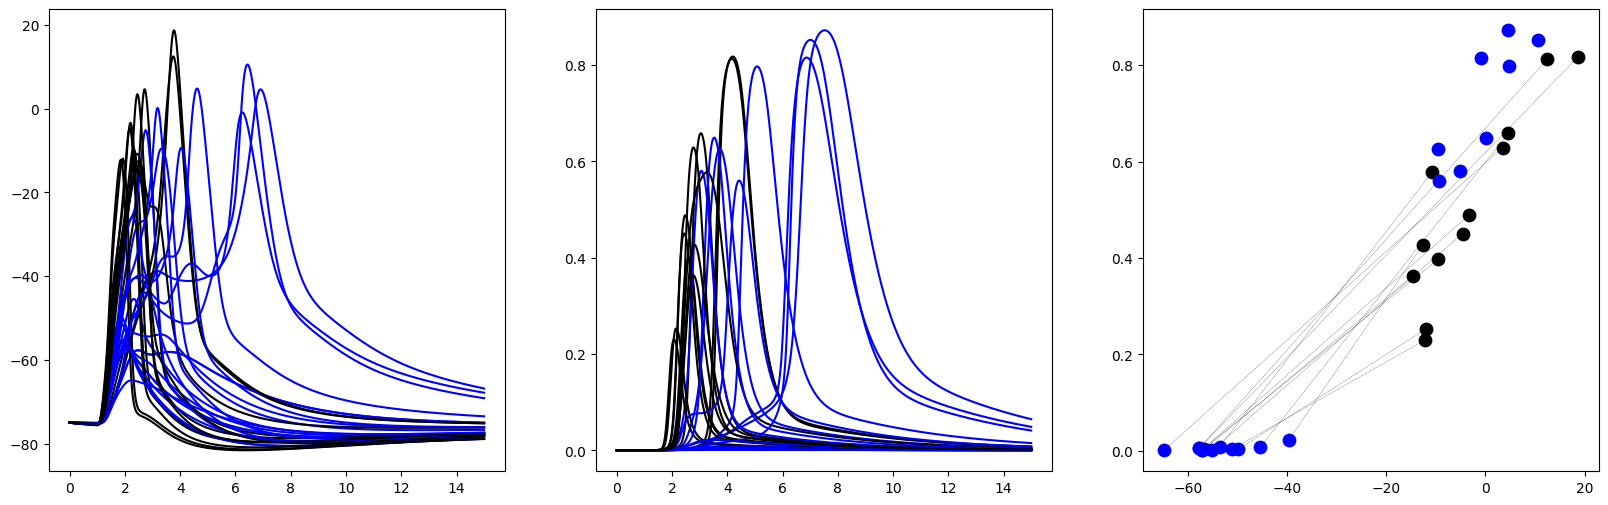

In [25]:
# Plot Somatic AP
fig = plt.figure(figsize=(20,6))

cmap = cm.get_cmap('jet')

numFits = len(kaDensity)

use_cut_experiment = 0

plt.subplot(1,3,1)
for n in range(numFits):
    if cutExperiment[n] != use_cut_experiment: continue
    c_cellID = cellID[n]
    numROI = vTraces[n].shape[0]
    for r in range(numROI):
        if cell_silentID[c_cellID][r]==False and idxROI[n]!=r: continue
        ccol = 'b'
        if cell_silentID[c_cellID][r]==False: ccol = 'k'
        plt.plot(np.array(tv[n]),vTraces[n][r].T,c=ccol)

plt.subplot(1,3,2)
for n in range(numFits):
    if cutExperiment[n] != use_cut_experiment: continue
    c_cellID = cellID[n]
    numROI = cTraces[n].shape[0]
    for r in range(numROI):
        if cell_silentID[c_cellID][r]==False and idxROI[n]!=r: continue
        ccol = 'b'
        if cell_silentID[c_cellID][r]==False: ccol = 'k'
        plt.plot(np.array(tv[n]),cTraces[n][r].T,c=ccol)

plt.subplot(1,3,3)
for n in range(numFits):
    if cutExperiment[n] != use_cut_experiment: continue
    c_cellID = cellID[n]
    numROI = cTraces[n].shape[0]
    for r in range(numROI):
        if cell_silentID[c_cellID][r]==False and idxROI[n]!=r: 
            continue
        ccol = 'b'
        if cell_silentID[c_cellID][r]==False: 
            ccol = 'k'
        plt.scatter(apAmp[n][r],caAmp[n][r],c=ccol,s=80)
    plt.plot([apAmp[n][0],apAmp[n][idxROI[n]]],[caAmp[n][0],caAmp[n][idxROI[n]]],c='k',linewidth=0.2,linestyle='dashed')

In [ ]:
cellID = 0
cutExperiment = 0
idxROI = 0

naDensity = 6
targetAmplitude = -20
initKaDensity = 0.01

results = minimize(determineKaDensity, initKaDensity, args=(targetAmplitude, cellID, cutExperiment, naDensity, idxROI),method='Nelder-Mead',bounds=(0,None))


In [10]:
# In this cell, I'll go through the cells and vary the potassium channel density until the requested ROI has an AP amplitude of a set voltage. 

numCells = 8 # number of cells to run through
naDensity = 6 # Na channel density (in channels / um2)
initKaDensity = 0.01 # K channel density (in units of S/cm2)
kaMinimum = 0 # minimum k channel density 
kaMaximum = 0.2 # maximum k channel density
stepSize = 0.00001 # ka S/cm2 per mV
tolerance = 0.05 # tolerance in mV for AP

# Index of ROI to set AP amplitude for
targetROI = [0,0,0,0,0,0,0,0]
targetAmplitude = 10 # target AP amplitude

cAP = np.Inf
cKa = initKaDensity
while np.abs(cAP - targetAmplitude) > tolerance:
    # Create cell
    for sec in h.allsec(): h.delete_section(sec=sec)
    cell1 = L23(cellID=1,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[cKa,np.inf,True,False],dxSeg=1,fixDiam=None);

    # Record response of AP at all desired sites
    stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection

    # Record peak of AP in all the sites
    vsec,tv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

    # Record ica in all sites + soma
    csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

    # Simulate Data
    nfx.simulate(tstop=8,v_init=-75,celsius=35)

    gca_sec = []
    for ica,v in zip(csec,vsec):
        gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))

    # Analyze Data
    vData = np.array(vsec)
    gcaData = np.array(gca_sec)
    apAmp = np.amax(vData,axis=1)
    gcAmp = np.amax(gcaData,axis=1)

    # Reset stim program
    stim1 = None

    cAP = apAmp[targetROI[0]]
    print(cAP)
    
    voltageError = (apAmp[targetROI[0]] - targetAmplitude)
    if voltageError>1: 
        updateValue = voltageError**2 * np.sign(voltageError) * stepSize
    else:
        updateValue = voltageError * stepSize
    newKa = cKa + updateValue
    if newKa > kaMaximum or newKa < kaMinimum:
        print(f'Out of range!! Ka:{newKa}')
        break
    cKa = newKa

    print(cKa)

In [73]:
testKa = 0.01871557
for sec in h.allsec(): h.delete_section(sec=sec)
cell1 = L23(cellID=0,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[testKa,np.inf,True,False],dxSeg=1,fixDiam=None);

# Record response of AP at all desired sites
stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection

# Record peak of AP in all the sites
vsec,tv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

# Record ica in all sites + soma
csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

# Simulate Data
nfx.simulate(tstop=8,v_init=-75,celsius=35)

gca_sec = []
for ica,v in zip(csec,vsec):
    gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))

# Analyze Data
vData = np.array(vsec)
gcaData = np.array(gca_sec)
apAmp = np.amax(vData,axis=1)
gcAmp = np.amax(gcaData,axis=1)

# Reset stim program
stim1 = None

print(apAmp[targetROI[0]])

	1 
-19.862718519098134


## Run example for EPSP simulation

In [36]:
testKa = 0.01871557
for sec in h.allsec(): h.delete_section(sec=sec)
cell1 = L23(cellID=0,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[testKa,np.inf,True,False],dxSeg=1,fixDiam=None);

stim = None
syn = None
onset=30
tau=2
gmax=0.0002
tstop = 100
vsection,vsoma,tv,syn = mfx.injectAlphaSites(cell1.sectionList,cell1.segmentList,syn=syn,onset=onset,tau=tau,gmax=gmax,tstop=tstop)
vsec = np.array(vsection)
vsoma = np.array(vsoma)
tv = np.array(tv)

	1 


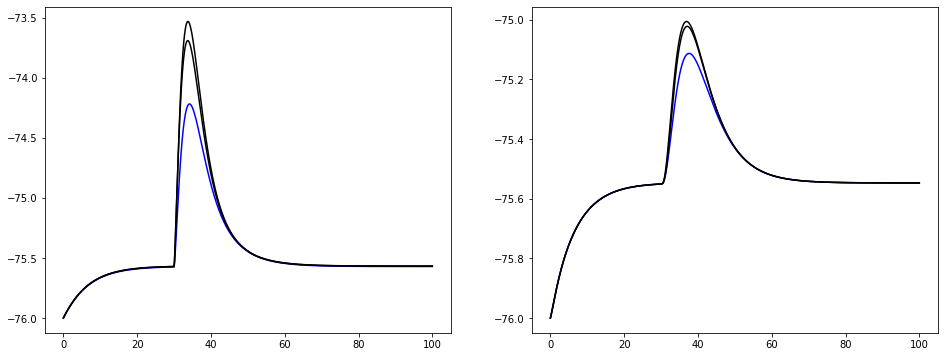

In [38]:
fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(tv,vsec[0].T,c='b')
for n in range(len(vsec)-1):
    plt.plot(tv,vsec[n+1].T,c='k')
plt.subplot(1,2,2)
plt.plot(tv,vsoma[0].T,c='b')
for n in range(len(vsoma)-1):
    plt.plot(tv,vsoma[n+1].T,c='k')

## Run example of K-Density AP fitting

In [12]:
cellID = 1
cutExp = 0
targetROI = 2
naDensity = 5
initKaDensity = 0.01
kaBounds = (0,None)
targetAmplitude = -10

# Create cell just to get silent IDs
for sec in h.allsec(): h.delete_section(sec=sec)
cell1 = L23(cellID=cellID,cutExperiment=cutExp,dendNa=[naDensity,None,None,False],dendK=[initKaDensity,np.inf,True,False],dxSeg=1,fixDiam=None);
cSilentID = cell1.silentID

results = minimize(determineKaDensity, initKaDensity, args=(targetAmplitude,cellID,cutExp,naDensity,targetROI),method='Nelder-Mead')

# Run cell with optimal kaDensity and record voltage/calcium traces for all ROIs in the cell
for sec in h.allsec(): h.delete_section(sec=sec)
cell1 = L23(cellID=cellID,cutExperiment=cutExp,dendNa=[naDensity,None,None,False],dendK=[results.x,np.inf,True,False],dxSeg=1,fixDiam=None);

# Record response of AP at all desired sites
stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection

# Record peak of AP in all the sites
vsec,ctv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

# Record ica in all sites + soma
csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

# Simulate Data
nfx.simulate(tstop=15,v_init=-75,celsius=35)

# Convert calcium current to conductance
gca_sec = []
for ica,v in zip(csec,vsec):
    gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))

print(np.amax(np.array(vsec),axis=1))
print(np.amax(np.array(gca_sec),axis=1))

# Run cell with optimal kaDensity and record voltage/calcium traces for all ROIs in the cell
for sec in h.allsec(): h.delete_section(sec=sec)
cell1 = L23(cellID=cellID,cutExperiment=2,dendNa=[naDensity,None,None,False],dendK=[results.x,np.inf,True,False],dxSeg=1,fixDiam=None);

# Record response of AP at all desired sites
stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection

# Record peak of AP in all the sites
vsec,ctv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

# Record ica in all sites + soma
csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

# Simulate Data
nfx.simulate(tstop=15,v_init=-75,celsius=35)

# Convert calcium current to conductance
gca_sec = []
for ica,v in zip(csec,vsec):
    gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))

print(np.amax(np.array(vsec),axis=1))
print(np.amax(np.array(gca_sec),axis=1))

	1 
	1 
[-57.15541556 -47.48945324 -10.00012429  -3.6262314 ]
[0.00235164 0.00616053 0.38798033 0.48423977]
	1 
[ -1.22404467 -43.55398527  -0.3795742    1.49898493]
[0.51479738 0.00920293 0.52791063 0.54793361]
